# TripRouter: Customized Trip Planner

## What is TripRouter

### A shortest path model which creates a trip plan according to distance, place ratings and user preferences.

## AHP Method

                                            Distance - Rating - Preferences
\begin{equation*}
\begin{vmatrix}
1 & \frac{1}{5} & \frac{1}{7} \\
5 & 1 & \frac{1}{3} \\
7 & 3 & 1
\end{vmatrix}
\end{equation*}

                                            Consistency Ratio is 0.06 < 0.1

## Floyd Warshall (All Pairs Shortest Path) With Exact K Edges

### - Floyd Warshall 2D

\begin{equation*}
dist(i, j) = min(dist(i, j), dist(i, a) + dist(a, j))\\
Complexity   = O(V^3)
\end{equation*}

### - Floyd Warshall 3D

\begin{equation*}
for(e:2..K):\\
dist(i, j) = min(dist(i, j, e), dist(i, a, 1) + dist(a, j, e - 1))\\
Complexity   = O(V^3 * K)
\end{equation*}

In [1]:
import numpy as np
from math import inf
from utils import timer

def get_path(pred, u, v, k):
    path = []
    node = pred[u][v][k]
    for i in range(k-1, 0, -1):
        path.append(node)
        node = pred[node][v][i]

    return [u] + path + [v]


@timer
def shortest_path(graph, k):
    print('Finding the shortest path')
    V = len(graph)

    sp = [[None] * V for _ in range(V)]
    pred = [[None] * V for _ in range(V)]

    for i in range(V):
        for j in range(V):
            sp[i][j] = [None] * (k + 1)
            pred[i][j] = [None] * (k + 1)

    for e in range(k + 1):
        for i in range(V):
            for j in range(V):
                sp[i][j][e] = inf

                if e == 0 and i == j:
                    sp[i][j][e] = 0
                if e == 1 and graph[i][j] != inf:
                    sp[i][j][e] = graph[i][j]

                if e > 1:
                    for a in range(V):
                        if graph[i][a] != inf and a not in [i, j] and sp[a][j][e - 1] != inf:
                            new_path_score = graph[i][a] + sp[a][j][e - 1]
                            if new_path_score < sp[i][j][e]:
                                pred_new = pred.copy()
                                pred_new[i][j][e] = a
                                new_path = get_path(pred_new, i, j, e)
                                if len(new_path) == len(set(new_path)):
                                    sp[i][j][e] = new_path_score
                                    pred[i][j][e] = a

    return np.array(sp), pred


def test(u, v, k):
    inf = 10**8
    graph = [[inf, 4, inf, inf, inf, inf, inf, 8, inf],
          [4, inf, 8, inf, inf, inf, inf, 11, inf],
          [inf, 8, inf, 7, inf, 4, inf, inf, 2],
          [inf, inf, 7, inf, 9, 14, inf, inf, inf],
          [inf, inf, inf, 9, inf, 10, inf, inf, inf],
          [inf, inf, 4, 14, 10, inf, 2, inf, inf],
          [inf, inf, inf, inf, inf, 2, inf, 1, 6],
          [8, 11, inf, inf, inf, inf, 1, inf, 7],
          [inf, inf, 2, inf, inf, inf, 6, 7, inf]]

    sp, pred = shortest_path(graph, k)

    print('FROM {} TO {} IN {} STEPS'.format(u, v, k))
    print('Cost is', sp[u][v][k])
    print('Path is', ' => '.join([str(i) for i in get_path(pred, u, v, k)]))

test(2, 6, 3)


Finding the shortest path
	Elapsed time: 0.0 seconds
FROM 2 TO 6 IN 3 STEPS
Cost is 10.0
Path is 2 => 8 => 7 => 6


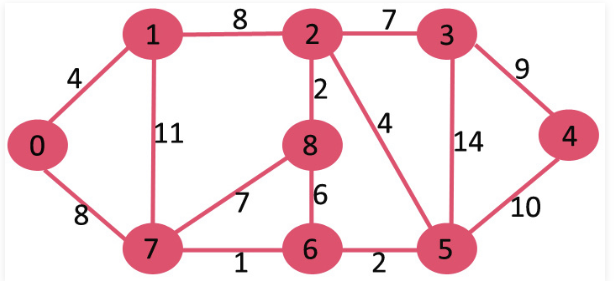

## Implementation For Trip Planning

### - Data

In [5]:
import json
from utils import display_map
from IPython.core.display import display, HTML

with open('graph.json', 'rb') as f:
    all_places = json.load(f)

for i in all_places:
    all_places[i]['name'] = ''
    
display(HTML(display_map(all_places)))


#### Location data for Istanbul is collected from TripAdvisor by TripAdvisor API.
#### The format of the data file is json.
#### An example of json element:

#### "ChIJMa09U_q5yhQR1Qv0Ii4F8s8": {
  * "name": "Golden Horn",
  * "lon": 28.9611125,
  * "lat": 41.0291684,
  * "id": "ChIJMa09U_q5yhQR1Qv0Ii4F8s8",
  * "rating": 4.6,
  * "rating_count": 381,
  * "category": ["landmark", "sightseeing", "historic"],
  * "neighbours": {
    * "ChIJnbx_x5e5yhQRlPF66tEpPfs": [
      * 123, // distance in meters
      * 432  // distance in time
    * ],
    * "ChIJDwwhAtq3yhQRCucO58KmTqo": [
      * 9774, // distance in meters
      * 3397  // distance in time]
    * ] 
    * ...
  * }
#### }

### - Model

In [6]:
import numpy as np
import json
from math import inf
from floyd import shortest_path, timer
from IPython.core.display import display, HTML
from utils import *


def ahp(comparison):
    comparison = np.array(comparison)
    random_index = [0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49]   
    criteria_w = np.mean(comparison / comparison.sum(axis=0), axis=1)
    lambda_max = np.mean(np.sum(comparison * criteria_w, axis=1) / criteria_w)
    consistency_index = (lambda_max - len(comparison)) / (len(comparison) - 1)
    consistency_ratio = consistency_index / random_index[len(comparison) - 1]
    print('Consistency Ratio is', round(consistency_ratio, 3))
    return criteria_w.tolist()


@timer
def init_graph(data, weights, prefs):
    print('Initializing the graph')
    V = len(data)
    graph = [[inf]*V for _ in range(V)]
    places = list(data.keys())
    for i in places:
        for j in data[i]['neighbours']:
            graph[places.index(i)][places.index(j)] = get_score(data, i, j, weights, prefs)

    return graph


@timer
def main(pref, K, ahp_scores):
    print('Model is in progress')
    with open('graph.json', 'rb') as f:
        data = json.load(f)

    K -= 1
    ahp_weights = ahp(ahp_scores)

    graph = init_graph(data, ahp_weights, set(pref))
    sp, pred = shortest_path(graph, K)
    path_ids, path_names = path_handler(data, sp, pred)
    print(' => '.join(path_names))
    
    return data, path_ids

### - User Input

In [7]:
from ipywidgets.widgets import Checkbox, HBox, VBox, IntSlider, Label
from IPython.display import display
from itertools import combinations


category_list = ['park', 'art', 'museum', 'landmark', 'amusement', 'shopping', 'sea_side', 'historic', 'sightseeing']
category_checkbox = [
    Checkbox(
        value=False,
        description=i,
        disabled=False
    )
    for i in category_list
]
display(Label('User Preferences'))
display(HBox([VBox(category_checkbox[i: i+3]) for i in range(0, len(category_checkbox), 3)]))
k_slider = IntSlider(min=4, max=10, value=6)
display(VBox([Label('Place Count'), k_slider]))

ahp_params = ['Distance', 'Rating', 'Preferences']
ahp_sliders = [[Label('{} - {}'.format(ahp_params[i], ahp_params[j])), IntSlider(min=-11, max=11, step=2, value=1)]
               for i, j in list(combinations(range(3), 2))]
display(HBox([VBox(i) for i in ahp_sliders]))

Label(value='User Preferences')

### - Output

In [8]:
ahp_scores = get_ahp_scores(ahp_sliders)
pref = [category_list[i] for i, x in enumerate([c.value for c in category_checkbox]) if x]
print('Preferences are', '({})'.format(', '.join(pref)))
data, path_ids = main(pref, k_slider.value, ahp_scores)
display(HTML(update_plot(data, path_ids)))

Preferences are ()
Model is in progress
Consistency Ratio is 0.0
Initializing the graph
	Elapsed time: 0.05 seconds
Finding the shortest path
	Ellapsed time is 2.9 seconds
Basilica Cistern => Topkapi Palace Museum => Hagia Sophia Museum => The Blue Mosque => Grand Bazaar => Suleymaniye Mosque
	Elapsed time: 2.97 seconds


TypeError: update_plot() takes 1 positional argument but 2 were given

# Further

### There is no consideration for timing.
### -    It does not recommend an amount of time to spend in a place.
### -    It does not check whether a place is open or close in any given time interval.

### Distances between places can be pointed out by routing instead of bird's eye view.